<a href="https://colab.research.google.com/github/shiyueamy/OnlineStore/blob/master/%E5%8D%81%E6%9C%88_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
import seaborn as sns

In [0]:
from google.colab import files
uploaded = files.upload()

import io
my_data = pd.read_csv(io.BytesIO(uploaded['Python_project_eda.csv']))

Saving Python_project_eda.csv to Python_project_eda.csv


In [0]:
# View data head
my_data.head(5)

,buyer_week_before,clicked_buy_before,country,existing_buyer,initial_fop_set,made_purchase_before,saw_cart_before,spend_usd_next_14_days,user_added_credit_card,user_added_dcb,user_added_fop,user_added_gift_card,user_added_paypal,user_id,visit_before
0,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,18321316048201303366,1
1,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,13705367724816913241,1
2,0,NaN,IN,0,False,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,6605724765451655114,0
3,0,1.0,CA,1,True,1.0,1.0,7.398815,1.0,0.0,1,0.0,0.0,2340067911948261502,1
4,7,1.0,PL,1,True,1.0,1.0,NaN,0.0,1.0,1,0.0,0.0,11891045596810635427,1


In [0]:
# shape of data
my_data.shape

(566699, 15)

**Check Missing Value**

In [0]:
# Remove Duplicates
my_data = my_data.drop_duplicates()

In [0]:
# double check
my_data.shape

(566699, 15)

In [0]:
# Check missing value
my_data.shape[0] - my_data.count()

buyer_week_before              0
clicked_buy_before         71059
country                    12524
existing_buyer                 0
initial_fop_set                0
made_purchase_before       71059
saw_cart_before            71059
spend_usd_next_14_days    477667
user_added_credit_card    396102
user_added_dcb            396102
user_added_fop                 0
user_added_gift_card      396102
user_added_paypal         396102
user_id                        0
visit_before                   0
dtype: int64

In [0]:
# remove NA in first part
df = my_data.dropna(subset = ['made_purchase_before', 'clicked_buy_before', 'country', 'saw_cart_before'])

# fill na with 0
df = df.fillna(0)

In [0]:
# Check missing value
df.shape[0] - df.count()

buyer_week_before         0
clicked_buy_before        0
country                   0
existing_buyer            0
initial_fop_set           0
made_purchase_before      0
saw_cart_before           0
spend_usd_next_14_days    0
user_added_credit_card    0
user_added_dcb            0
user_added_fop            0
user_added_gift_card      0
user_added_paypal         0
user_id                   0
visit_before              0
dtype: int64

In [0]:
# The length of data now
len(df)

484357

**Exploration - Spend USD in next 14 Days**

In [0]:
spend_usd_next_14_days = df.spend_usd_next_14_days

In [0]:
spend_usd_next_14_days.describe()

count    484357.000000
mean         12.066857
std          94.333699
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       22519.570000
Name: spend_usd_next_14_days, dtype: float64

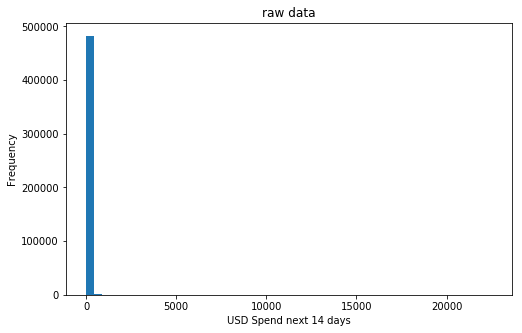

In [0]:
plt.hist(spend_usd_next_14_days, bins = 50)
plt.xlabel("USD Spend next 14 days")
plt.ylabel("Frequency")
plt.title("raw data")
plt.show()

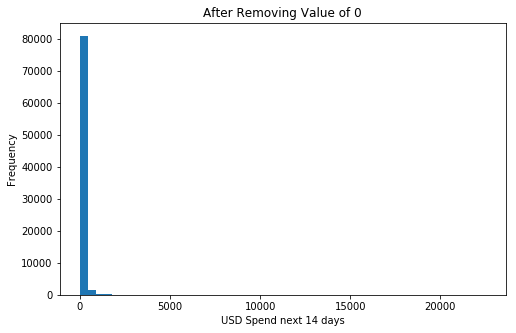

In [0]:
plt.hist(spend_usd_next_14_days[spend_usd_next_14_days != 0], bins = 50)
plt.xlabel("USD Spend next 14 days")
plt.ylabel("Frequency")
plt.title("After Removing Value of 0")
plt.show()

In [0]:
n = len(spend_usd_next_14_days) + 0.0
print('# users who spend $ larger than 100 USD', len(spend_usd_next_14_days[spend_usd_next_14_days >= 100]) / n)
print('# users who spend $ larger than 500 USD', len(spend_usd_next_14_days[spend_usd_next_14_days >= 500]) / n)

# users who spend $ larger than 100 USD 0.027572637538014314
# users who spend $ larger than 500 USD 0.003749300619171396


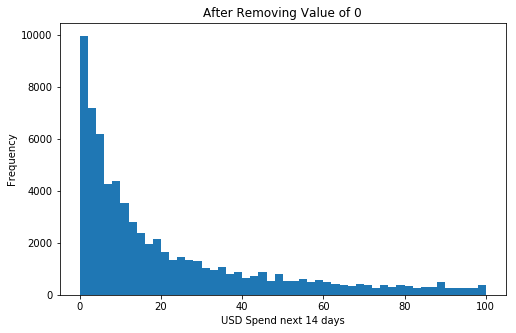

In [0]:
plt.hist(spend_usd_next_14_days[(spend_usd_next_14_days != 0) & (spend_usd_next_14_days <= 100)], bins = 50)
plt.xlabel("USD Spend next 14 days")
plt.ylabel("Frequency")
plt.title("After Removing Value of 0")
plt.show()

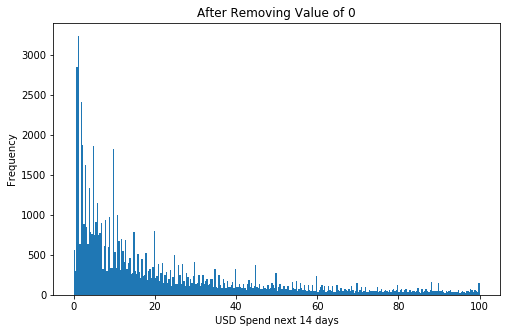

In [0]:
plt.hist(spend_usd_next_14_days[(spend_usd_next_14_days != 0) & (spend_usd_next_14_days <= 100)], bins = 300)
plt.xlabel("USD Spend next 14 days")
plt.ylabel("Frequency")
plt.title("After Removing Value of 0")
plt.show()

In [0]:
# If purchased before...
purchased = df[df['made_purchase_before'] == 1]
purchased_spend_rate = len(purchased[purchased['spend_usd_next_14_days'] != 0]) / (len(purchased) + 0.0)

# print results
print('If purchased before, the spend rate is: ', purchased_spend_rate)

If purchased before, the spend rate is:  0.7309907664530816


**Purchase Funnel**

In [0]:
# for each stage
n_total = len(my_data)
n_visited = len(df)
n_saw = df['saw_cart_before'].sum()
n_clicked = df['clicked_buy_before'].sum()
n_purchased = df['made_purchase_before'].sum()

# create dataframe
funnel_df = pd.DataFrame(columns=['action', 'num', 'cr_stage'])
funnel_df['action'] = ['visited', 'saw', 'clicked', 'purchased']
funnel_df['num'] = [n_visited, n_saw, n_clicked, n_purchased]
# cr_stage = # of each stage / # of total
funnel_df['cr_stage'] = np.array([n_visited, n_saw, n_clicked, n_purchased]) / n_total

# print table
print('Number of users and converrsion rate for each stage:')
print(funnel_df)

Number of users and converrsion rate for each stage:
      action       num  cr_stage
0    visited  484357.0  0.854699
1        saw  451933.0  0.797483
2    clicked  124233.0  0.219222
3  purchased  101911.0  0.179833


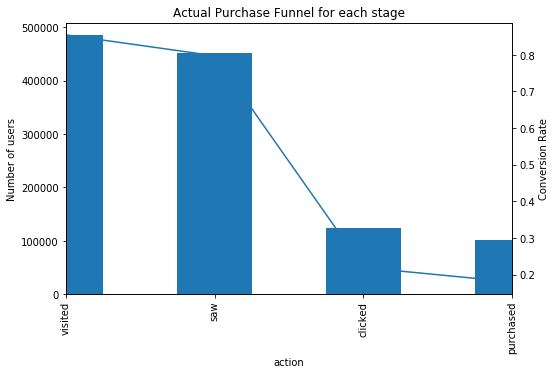

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
funnel_df.plot.bar('action','num', ax = ax1, legend=False)
funnel_df.plot('action','cr_stage', ax = ax2, legend=False)
ax1.set_ylabel('Number of users')
ax2.set_ylabel('Conversion Rate')
ax1.set_title('Actual Purchase Funnel for each stage')
plt.show()

In [0]:
funnel_df['stage_stage'] = ['begin_visited', 'visited_saw', 'saw_clicked', 'clicked_purchase']
funnel_df['cr_from_to'] = [n_visited/(n_total + 0.0), n_saw/n_visited, n_clicked/n_saw, n_purchased/n_clicked]
print('conversation rate stage-to-stage')
print(funnel_df[['stage_stage', 'cr_from_to']])

conversation rate stage-to-stage
        stage_stage  cr_from_to
0     begin_visited    0.854699
1       visited_saw    0.933058
2       saw_clicked    0.274893
3  clicked_purchase    0.820321


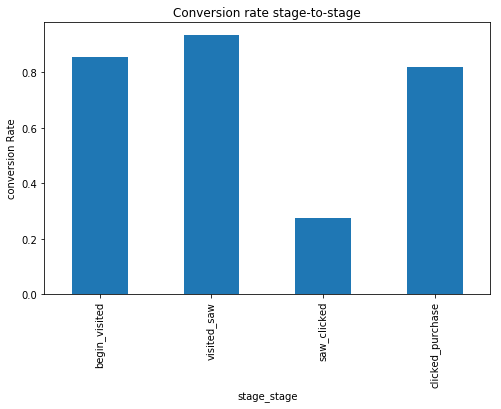

In [0]:
funnel_df.plot.bar('stage_stage','cr_from_to', legend = False)
plt.ylabel('conversion Rate')
plt.title('Conversion rate stage-to-stage')
plt.show()

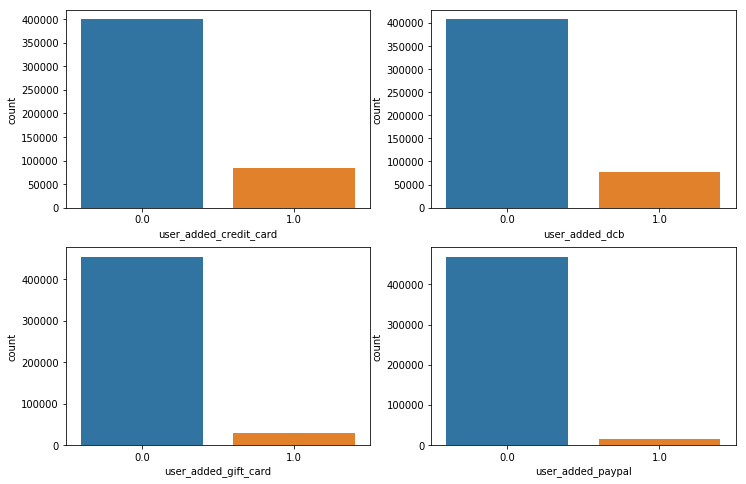

In [0]:
# find the distribution of payment method
target_features = ['user_added_credit_card', 'user_added_dcb', 'user_added_gift_card','user_added_paypal']

# categorical histograms
fig = plt.figure(figsize = (12, 8))
for i, column in enumerate(target_features):
  fig.add_subplot(2, 2, i+1)
  sns.countplot(df[column])

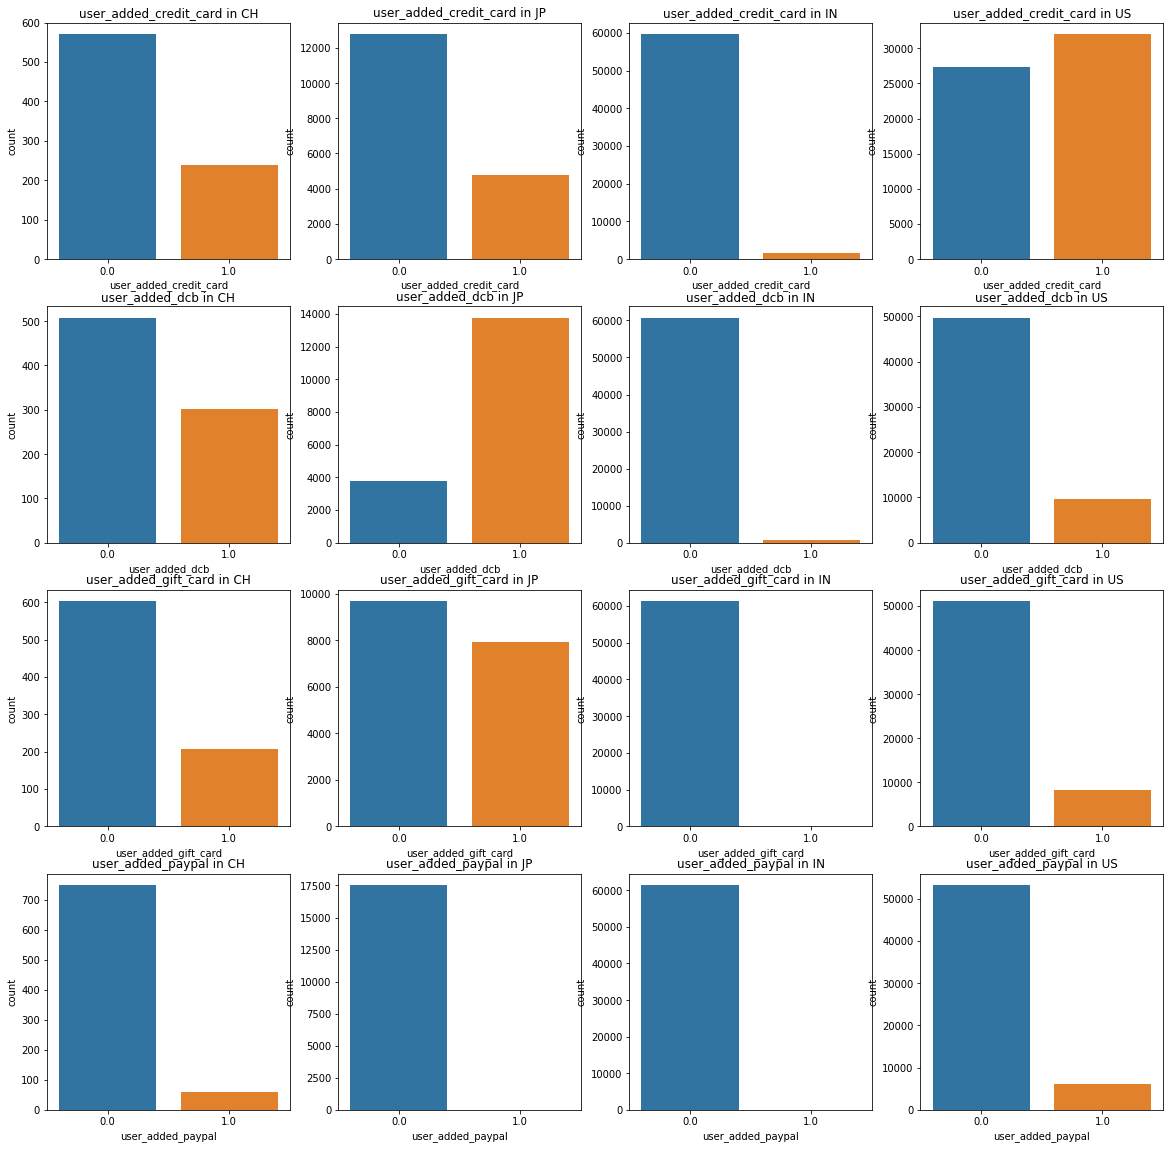

In [0]:
# Analyst through different country
country = ['CH', 'JP', 'IN', 'US']
count = 1
fig = plt.figure(figsize = (20, 20))
for i, fop in enumerate(target_features):
  for j,c in enumerate(country):
    fig.add_subplot(4, 4, count)
    sns.countplot(df[df['country'] == c][fop])
    plt.title(fop + ' in ' + c)
    count += 1

In [0]:
# Add multiple payment method vs Add single payment method
def cr_fop(stage_interval, obj, df):
  tmp = df[df[obj] == 1][stage_interval].sum()
  return tmp[1] / tmp[0]

stage_interval = ['clicked_buy_before', 'made_purchase_before']

# Calculate muptiple for conversion rate
multiple_fop = []
for obj in target_features:
  cr = cr_fop(stage_interval, obj, df)
  multiple_fop.append(cr)


# Calculate single fop conversion rate
df['user_added_sum'] = df['user_added_credit_card'] + df['user_added_dcb'] + df['user_added_gift_card'] + df['user_added_paypal']
single_fop_df = df[df['user_added_sum'] == 1]
single_fop = []
for obj in target_features:
  cr = cr_fop(stage_interval, obj, single_fop_df)
  single_fop.append(cr)

In [0]:
single_fop_df[target_features].sum()

user_added_credit_card    51320.0
user_added_dcb            47251.0
user_added_gift_card       9326.0
user_added_paypal          5197.0
dtype: float64

FOP conversation rate:
                      fop  multiple_fop  single_fop
0  user_added_credit_card      0.863623    0.809564
1          user_added_dcb      0.814635    0.711575
2    user_added_gift_card      0.960136    0.953946
3       user_added_paypal      0.883465    0.784256


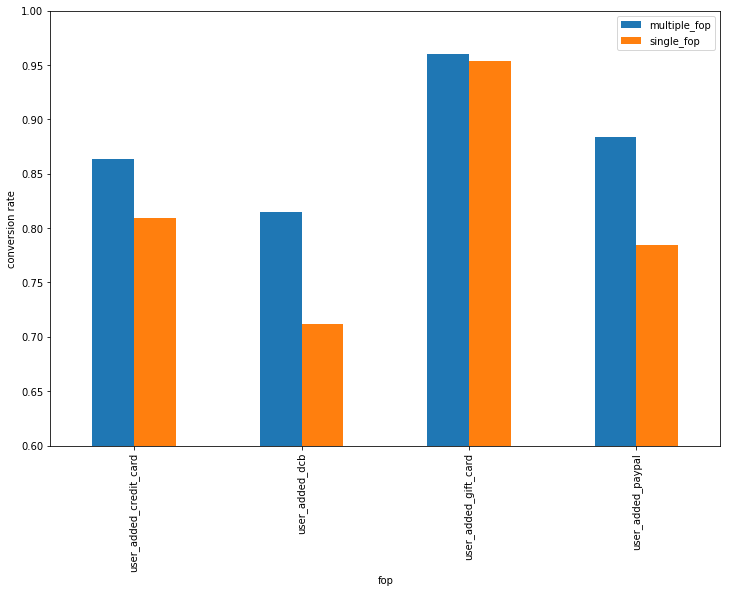

In [0]:
# draw bar plot
res_fop_df = pd.DataFrame(columns = ['fop', 'multiple_fop', 'single_fop'])
res_fop_df['fop'] = target_features
res_fop_df['multiple_fop'] = multiple_fop
res_fop_df['single_fop'] = single_fop
print('FOP conversation rate:')
print(res_fop_df)

res_fop_df.plot.bar(x = 'fop', y = ['multiple_fop', 'single_fop'], figsize = (12, 8))
plt.ylim(0.6, 1,0)
plt.ylabel('conversion rate') vrjuo.hbo
plt.show()